## A/B - тестирование

Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста, когда-то проходившего у меня. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:
* Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
* Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

df = pd.read_csv('ab_test_ensembles.csv')

In [2]:
df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


### Подготовка датасета к экспериментам

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


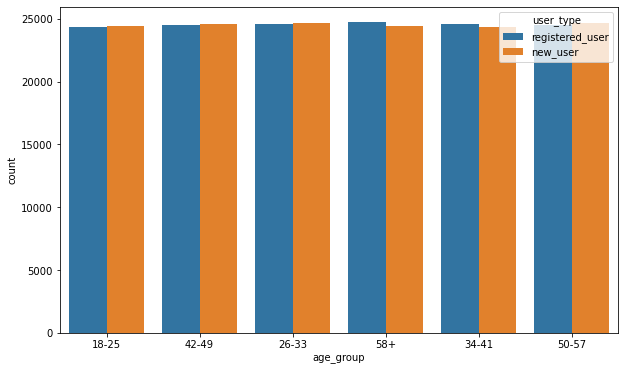

In [4]:
plt.figure(figsize=(10,6))
sns.countplot(x = 'age_group', hue = 'user_type', data = df);

В сформированной выборке равномерно распределены новые и зарегистрированные пользователи по группам возрастов.

Проверим, если в нашей выборке дубликаты по user_id

In [5]:
session_users = df['user_id'].value_counts(ascending=False)
duplicate_users = session_users[session_users > 1].count()
print('В выборке {} дублирующихся пользователей.'.format(duplicate_users))

В выборке 0 дублирующихся пользователей.


По условию задания нам нужно проверить, помогает ли новая версия увеличить уровень конверсии на два процента. Посчитаем выборочное среднее для контрольной группы.

In [6]:
round(df.loc[df['group'] == 'control']['converted'].mean(),2)

0.12

Проведем анализ мощности выборки и посчитаем, сколько пользователей необходимо для проведениия A/B теста, чтобы проверить предположение о повышении уровня конверсии с 12 до 14 процентов.

In [7]:
effect_size = sms.proportion_effectsize(0.12, 0.14)
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)
required_n = ceil(required_n)

print('Для каждой группы нам необходимо не меньше {} наблюдений.'.format(required_n))

Для каждой группы нам необходимо не меньше 4433 наблюдений.


In [8]:
pd.crosstab(df['group'],df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


Наша выборка много больше посчитанного числа, будем использовать все записи.

### Подсчет выборочных статистик

In [9]:
conversion_rates = df.groupby('group')['converted']

std_proportion = lambda x: np.std(x, ddof=0)
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118920,0.323694,0.000843


Стандартная ошибка очень схожа для контрольной и экспериментальной групп сформированной выборки. Выборочное среднее и стандартное отклонение для экспериментальной группы ниже на 0.2%, чем для контрольной.

### Тестирование гипотез

Сформируем нулевую и альтернативную гипотезы. Наша задача проверить, будет ли новая модель svm_ensemble работать лучше, чем standard. Для этих целей подойдет двусторонний статистический тест. 

H0 : p  = p0
H1 : p != p0,
где p и p0 означают коэффициенты конверсии между новым и старым вариантами соответственно. 

Так же необходимо выбрать уровень доверия (confidence level). В нашем случае мы решили что это будет 95%.
Имея уровень доверия в 95% необходимо рассчитать показатель альфа, который будет равен (1 - 0.95) для нашего теста = 0.05.

In [10]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.24
p-value: 0.216
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


Посчитанное значение p-value равно 0.216 и оно выше, заданного показателя альфа, 0.05. Это означает, что нулевая гипотеза не будет отвергнута, а новая и старая модели выдают схожие показатели конверсии.

Попробуем разбить нашу выборку по целевой метке тип клиента.

In [11]:
pd.crosstab([df['user_type'],df['group']],df['variants'])

variants                   standard  svm_ensemble_v_1_22
user_type       group                                   
new_user        control       72791                  959
                treatment      1006                72482
registered_user control       72483                  969
                treatment       959                72829

Видим, что данных для проведения тестирования гипотез также выше, чем требуемых 4433 наблюдения.

In [12]:
conversion_rates = df.groupby([df['user_type'],df['group']])['converted']

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

CR mean    CR std     CR se
user_type       group                                  
new_user        control    0.120746  0.325832  0.001200
                treatment  0.117557  0.322082  0.001188
registered_user control    0.120051  0.325021  0.001199
                treatment  0.120277  0.325285  0.001197

Мы видим, что выборочное среднее и стандартное отклонение для зарегистрированных пользователей фактически одинаковы, быть может это значит, что версии модели не влияют на уровень конверсии. Проверим это, посчитав z-статистику.

In [13]:
control_results = df[(df['group'] == 'control') & (df['user_type'] == 'registered_user')]['converted']
treatment_results = df[(df['group'] == 'treatment') & (df['user_type'] == 'registered_user')]['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: -0.13
p-value: 0.894
CI 95% for control group: [0.118, 0.122]
CI 95% for treatment group: [0.118, 0.123]


Посчитанное значение p-value равно 0.894 и оно выше, заданного показателя альфа, 0.05. Это означает, что нулевая гипотеза не будет отвергнута, а новая и старая модели для зарегистрированных пользователей выдают схожие показатели конверсии.

Проведем тестирования гипотез для групп новых пользователей.

In [14]:
control_results = df[(df['group'] == 'control') & (df['user_type'] == 'new_user')]['converted']
treatment_results = df[(df['group'] == 'treatment') & (df['user_type'] == 'new_user')]['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.02)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.89
p-value: 0.059
CI 95% for control group: [0.118, 0.124]
CI 95% for treatment group: [0.115, 0.120]


Для групп новых пользователей значение p-value близко к нашему уровню значимости, однако этого недостаточно, чтобы отвергнуть нулевую гипотезу, контрольная и экспериментальная группы выдают схожие уровни конверсии.

В качестве предположения:
   1. Через выбранное время собрать датасет снова, новых пользователей должно быть больше. 
   2. Собрать контрольную и экспериментальную группы и провести тестирования гипотез снова. 

Также стоит отметить, что на модели svm_ensemble выборочное среднее коэффициента конверсии для групп пользователей либо такое же, либо ниже. Необходимо оставить старый вариант модели.